Load the dataset and split it into training, validation and test sets.

In [15]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras

processed_path = "../../data/processed/amazon_reviews_processed.csv"
df = pd.read_csv(processed_path)

#some basic info about the dataset
print("dataset shape:", df.shape)
print(df.head())
print(df.columns)

#convert polarity to binary labels
df['label'] = df['polarity'].map({1: 0, 2: 1})

#define features and labels
X = df['cleaned_review']
y = df['label']

#split the data into training, validation and test sets
#stratify ensures that the class distribution is the same in all sets
#starting with a 60/20/20 split, can change the split later
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size = 0.25, random_state = 42, stratify = y_train)

print("Training set size: ", len(X_train))
print("Validation set size: ", len(X_val))
print("Test set size: ", len(X_test))


dataset shape: (199982, 5)
   polarity                                              title  \
0         2                     Stuning even for the non-gamer   
1         2              The best soundtrack ever to anything.   
2         2                                           Amazing!   
3         2                               Excellent Soundtrack   
4         2  Remember, Pull Your Jaw Off The Floor After He...   

                                                text  \
0  This sound track was beautiful! It paints the ...   
1  I'm reading a lot of reviews saying that this ...   
2  This soundtrack is my favorite music of all ti...   
3  I truly like this soundtrack and I enjoy video...   
4  If you've played the game, you know how divine...   

                                         full_review  \
0  Stuning even for the non-gamer This sound trac...   
1  The best soundtrack ever to anything. I'm read...   
2  Amazing! This soundtrack is my favorite music ...   
3  Excellent So

Now we build the CNN architecture. We start with an embedding layer to convert the integer sequences to dense vector representations. Then we add our convolutional layers, maxing pooling layers and dense layers.

c:\Users\adamy\Documents\DAT255-Project\env\Lib\site-packages\keras\src\layers\core\embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


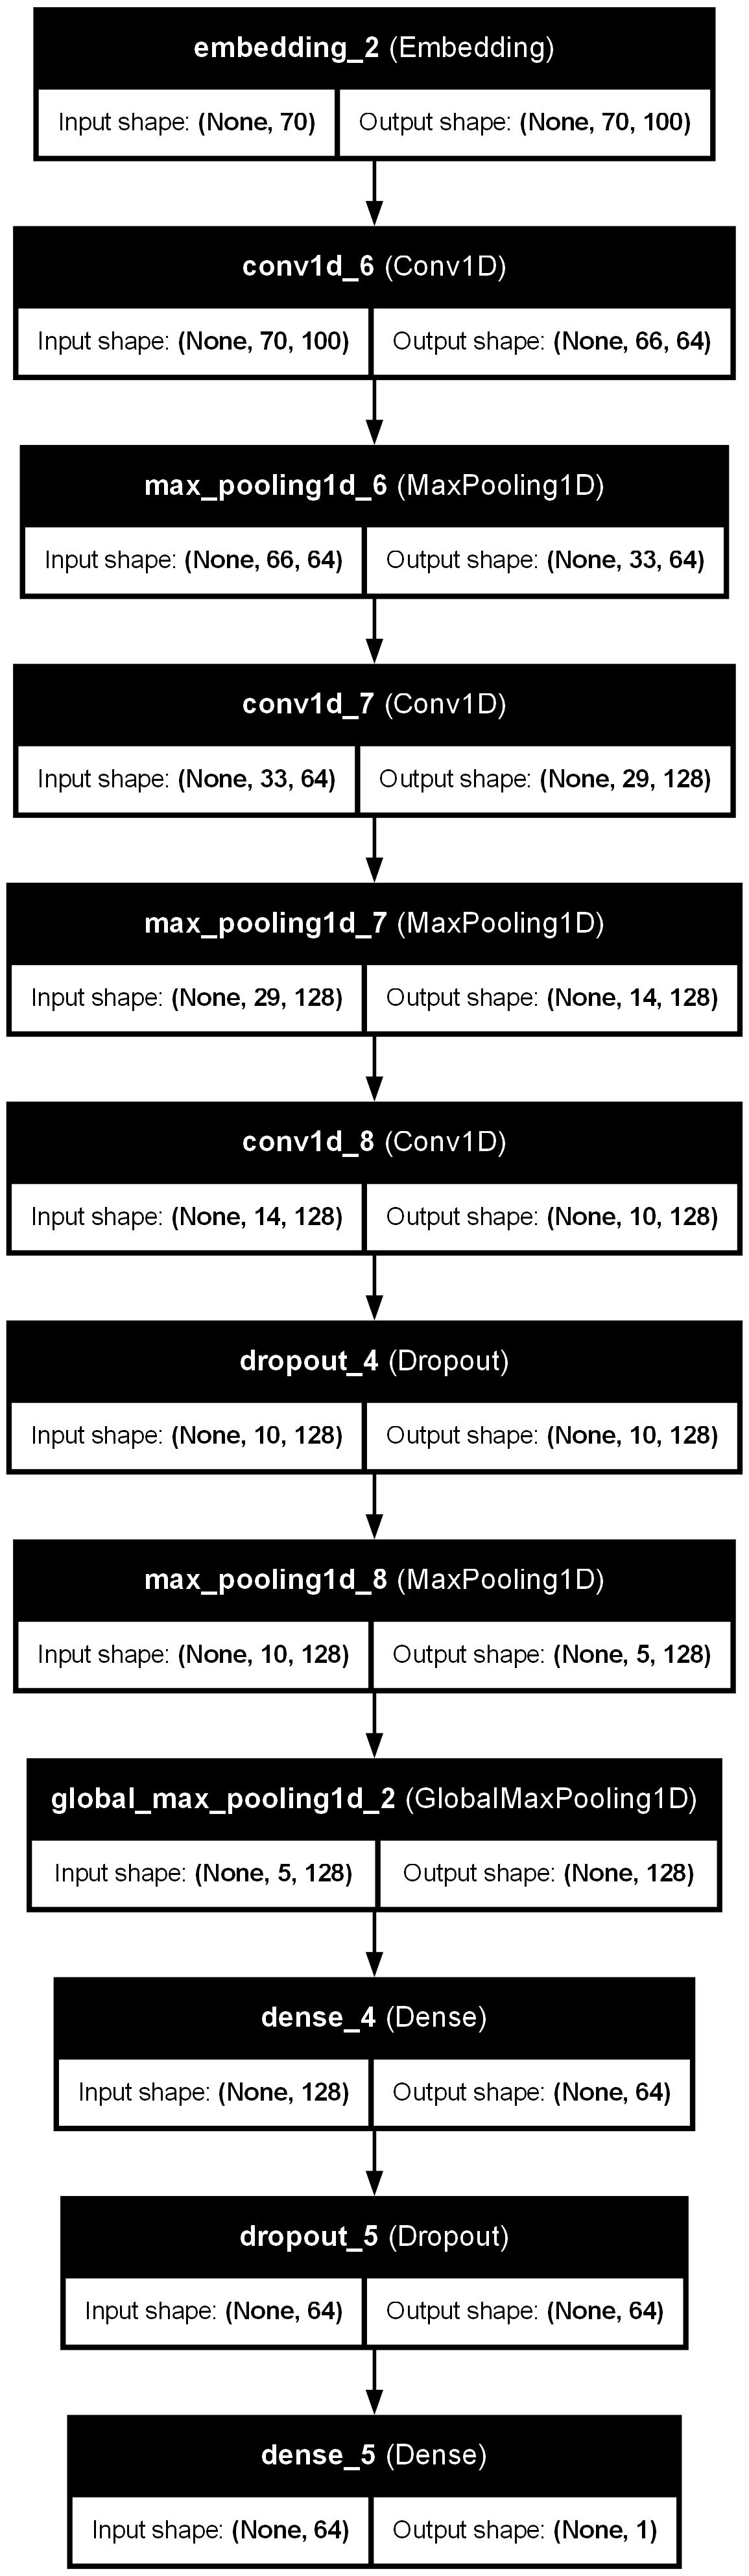

In [16]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model


max_vocab = 10000
embedding_dim = 100
maxlen = 70

model = Sequential([
    Embedding(
        input_dim = max_vocab,
        output_dim = embedding_dim,
        input_shape=(maxlen,)
        ),

    Conv1D(64, 5, activation='relu'),
    MaxPooling1D(2),

    Conv1D(128, 5, activation='relu'),
    MaxPooling1D(2),

    Conv1D(128, 5, activation='relu'),
    Dropout(0.3),
    MaxPooling1D(2),

    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

# plot the model architecture
plot_model(model, show_shapes=True, show_layer_names=True, to_file='cnn_architecture.png', rankdir='TB')

Now we compile the model, using an optimizer like Adam or RMSprop. We use binary crossentropy for binary sentiment classification. Finally we set the evaluation metrics, like for example accuracy.

In [17]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss = 'binary_crossentropy', metrics = ['accuracy'])

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 70, 100)        │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 66, 64)         │        32,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 33, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 29, 128)        │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_7 (MaxPooling1D)  │ (None, 14, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 10, 128)        │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_8 (MaxPooling1D)  │ (None, 5, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_2          │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,163,521 (4.44 MB)

 Trainable params: 1,163,521 (4.44 MB)

 Non-trainable params: 0 (0.00 B)

The model is built, and we will move on to training the model. For this part we'll define the number of epochs, batches any callbacks (like early stopping) to prevent overfitting. Afterwards, we'll train the model on the training data and validate the validation set. An important step is to monitor the loss and accuracy during training.

Before we start the training, we need to format our data correctly. Because we split our data into training, test and validation sets, the data is in text format, but our model expects numerical sequences. Lets correct the format using a tokenizer then padding the sequences.

In [18]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

print("Data types in X_train:")
print(X_train.dtypes)

print("\nNumber of non-string values:")
print(X_train.apply(lambda x: not isinstance(x, str)).sum())

print("\nNumber of NaN values:")
print(X_train.isna().sum())

# Find the problematic value
for idx, text in enumerate(X_train):
    if not isinstance(text, str):
        print(f"Problematic value at index {idx}: {text}")
        print(f"Type: {type(text)}")

# Handle the problematic values
X_train = X_train.fillna('')  # Replace NaN with empty string
X_train = X_train.astype(str)  # Convert all to strings
X_val = X_val.fillna('')  # Replace NaN with empty string
X_val = X_val.astype(str)  # Convert all to strings
                     
# Verify the fix
print("\nAfter cleaning:")
print("Number of non-string values:", X_train.apply(lambda x: not isinstance(x, str)).sum())
print("Number of NaN values:", X_train.isna().sum())

#create and fit tokenizer
tokenizer = Tokenizer(num_words=max_vocab)
tokenizer.fit_on_texts(X_train)

#convert text to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)

#pad sequences to maxlen 
X_train_pad = pad_sequences(X_train_seq, maxlen=maxlen, padding='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=maxlen, padding='post')

# read on the internet that 3 epochs is good for sentiment analysis, but i wrote 10 epochs with an early stopping 
# callback to prevent overfitting and stop the training when the validation loss stops improving
history = model.fit(X_train_pad, y_train, epochs = 20, batch_size = 64, validation_data = (X_val_pad, y_val), 
                    callbacks = [
                        EarlyStopping(monitor = 'val_loss', patience = 2, restore_best_weights = True),
                        ModelCheckpoint(filepath = '../../models/cnn/best_model.keras', monitor = 'val_loss', save_best_only = True),
                        ])


Data types in X_train:
object

Number of non-string values:
0

Number of NaN values:
0

After cleaning:
Number of non-string values: 0
Number of NaN values: 0
Epoch 1/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 24s 12ms/step - accuracy: 0.7845 - loss: 0.4185 - val_accuracy: 0.8817 - val_loss: 0.2893
Epoch 2/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 23s 12ms/step - accuracy: 0.9144 - loss: 0.2193 - val_accuracy: 0.8867 - val_loss: 0.2767
Epoch 3/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 23s 12ms/step - accuracy: 0.9492 - loss: 0.1349 - val_accuracy: 0.8813 - val_loss: 0.3098
Epoch 4/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 24s 13ms/step - accuracy: 0.9770 - loss: 0.0669 - val_accuracy: 0.8749 - val_loss: 0.3973


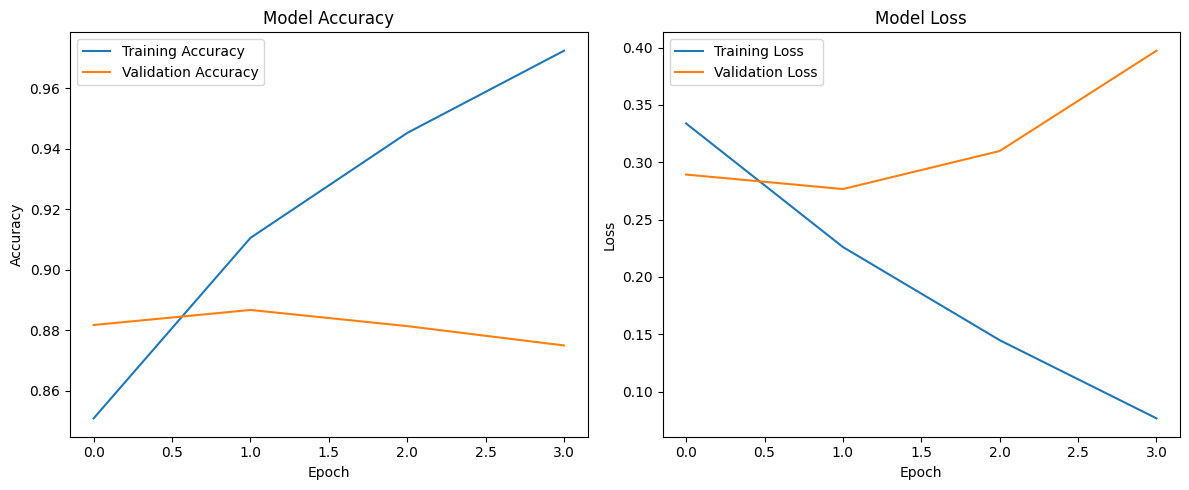

<Figure size 640x480 with 0 Axes>

In [19]:
# Plot training history
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

plt.tight_layout()
plt.show()

#saving our tokenizer for use in the evaluation notebook
import pickle
with open('../../models/cnn/tokenizer.pickle', 'wb') as handle: 
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)